# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 7-7.5

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [11]:
y_train

array([1, 1, 0, ..., 0, 0, 0])

In [12]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: почитав доку, я понял, что predict_proba выдает вероятности предсказания классов.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [13]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75950
AUC-ROC: 0.50000


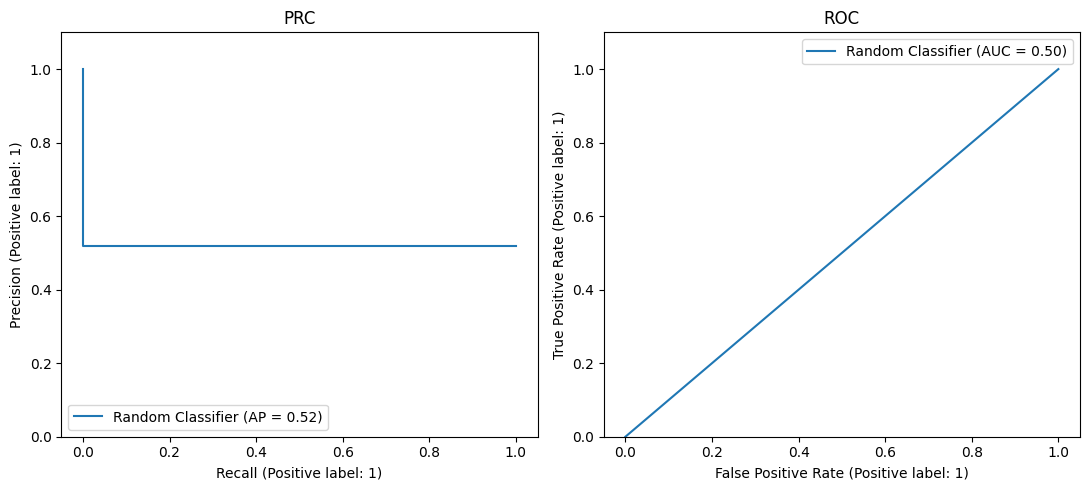

In [14]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [15]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.7595,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [55]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [56]:
def auc_pr_count(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

In [57]:
grid_l = GridSearchCV(LinearSVC(), {'C': np.linspace(-15, 15, 10)},
                    scoring=make_scorer(auc_pr_count), cv=5)
grid_l.fit(X_train, y_train)
grid_l.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

{'C': 5.0}

In [64]:
grid_l.best_score_

0.827968638841216

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Linear SVC Classifier metrics
AUC-PR: 0.81061
AUC-ROC: 0.84500


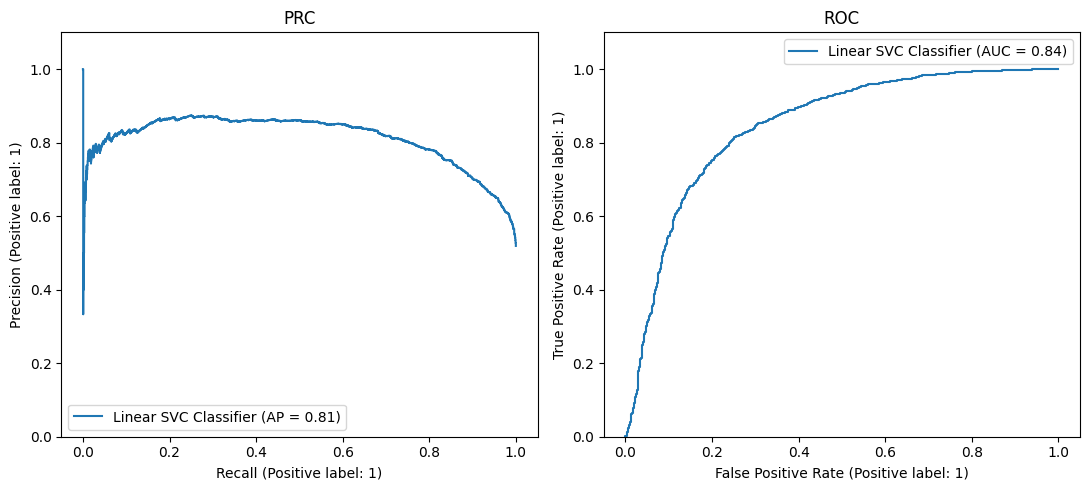

In [65]:
#your code here
y_svc = grid_l.decision_function(X_test)

depict_pr_roc(y_test, y_svc, 'Linear SVC Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [66]:
#your code here
precision, recall, _ = precision_recall_curve(y_test, y_svc)
df_metrics.loc['Linear SVC Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_svc),
      0
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.759500,0.500000,0.0
Linear SVC Classifier,0.810606,0.844997,0.0
Logistic Regression SVC Classifier,0.827244,0.850613,0.0
Logistic Regression Classifier,0.827240,0.850608,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [21]:
from sklearn.linear_model import LogisticRegression

In [67]:
#your code here
grid_lr = GridSearchCV(LogisticRegression(), param_grid={'C': np.linspace(-15, 20, 40)},
                    scoring=make_scorer(auc_pr_count), cv=5)
grid_lr.fit(X_train, y_train)
grid_lr.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
85 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklear

{'C': 1.1538461538461533}

Logistic Regression Classifier metrics
AUC-PR: 0.82724
AUC-ROC: 0.85061


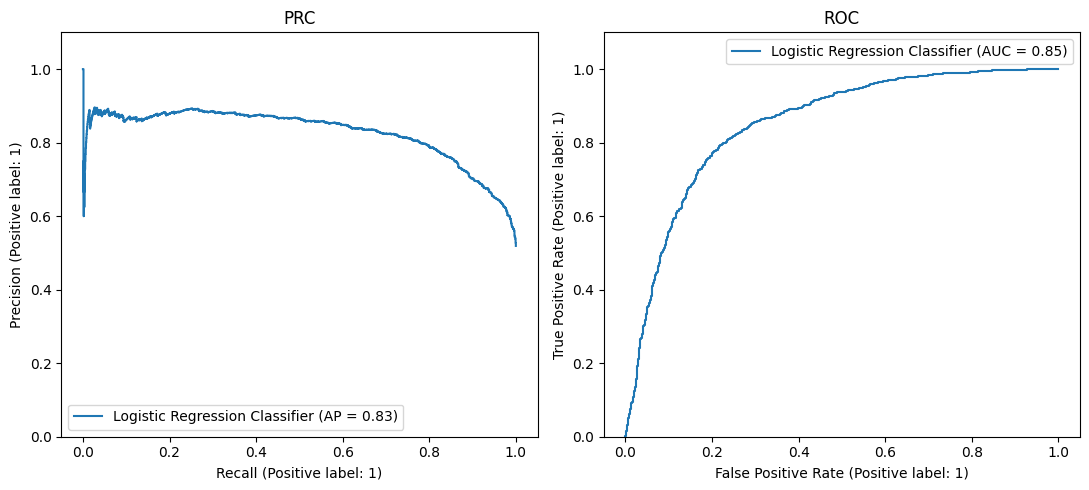

In [68]:
y_lr = grid_lr.predict_proba(X_test)[:, 1]

depict_pr_roc(y_test, y_lr, 'Logistic Regression Classifier')

In [69]:
precision, recall, _ = precision_recall_curve(y_test, y_lr)
df_metrics.loc['Logistic Regression Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_lr),
      0
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.759500,0.500000,0.0
Linear SVC Classifier,0.810606,0.844997,0.0
Logistic Regression SVC Classifier,0.827244,0.850613,0.0
Logistic Regression Classifier,0.827240,0.850608,0.0


тут случайно 3 строка добавилась, скип ее))

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

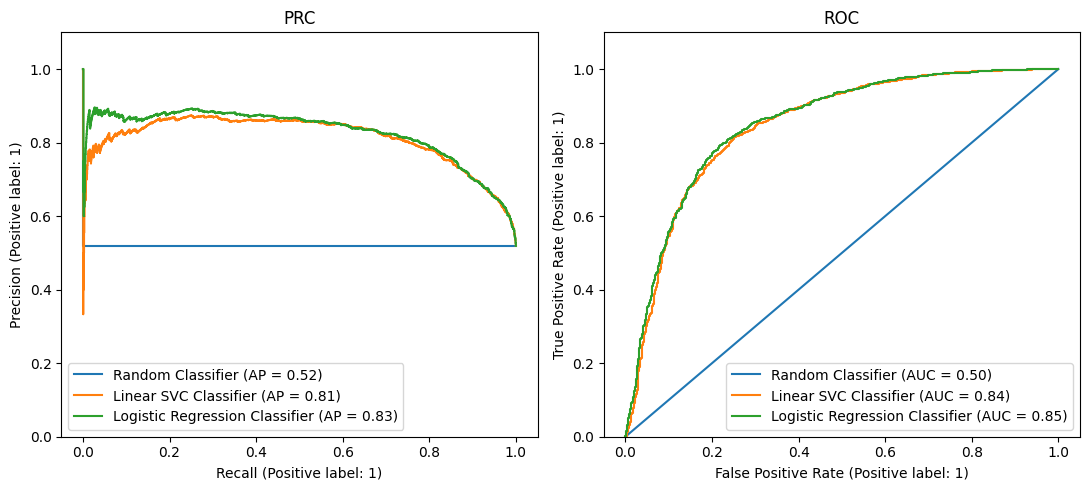

In [70]:
#your code here
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random Classifier')
precision, recall, _ = precision_recall_curve(y_test, y_random)
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random Classifier')
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

PrecisionRecallDisplay.from_predictions(y_test, y_svc, ax=ax[0], name='Linear SVC Classifier')
RocCurveDisplay.from_predictions(y_test, y_svc, ax=ax[1], name='Linear SVC Classifier')

PrecisionRecallDisplay.from_predictions(y_test, y_lr, ax=ax[0], name='Logistic Regression Classifier')
RocCurveDisplay.from_predictions(y_test, y_lr, ax=ax[1], name='Logistic Regression Classifier')

plt.tight_layout()
plt.legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** в целом результаты одинаковые +-, только в начале Linear SVC просел по качеству, а так результат такой же, наверно, потому что данные синтетические, а не настоящие

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [75]:
#your code here
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=777)
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

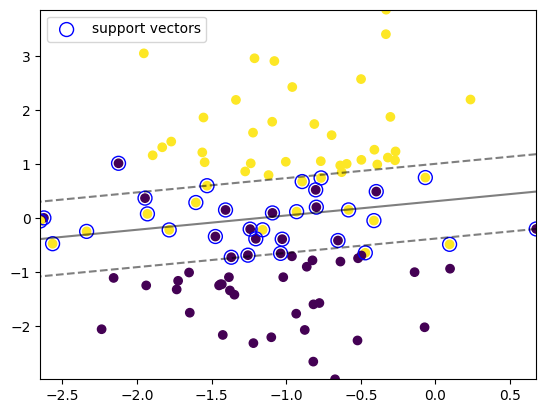

In [76]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те, что лежат между граничными прямыми и те, которые попали не в свой класс

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [77]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

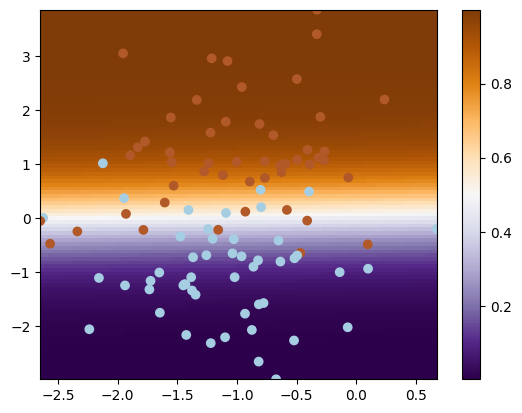

In [78]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1].reshape(XX.shape)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** область, где модель не уверена $$p(y=+1|x)=0.5$$ - белая полоса между двумя классами.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [106]:
def plot_calibration_curve(y_test, preds, label=""):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label=label)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [111]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

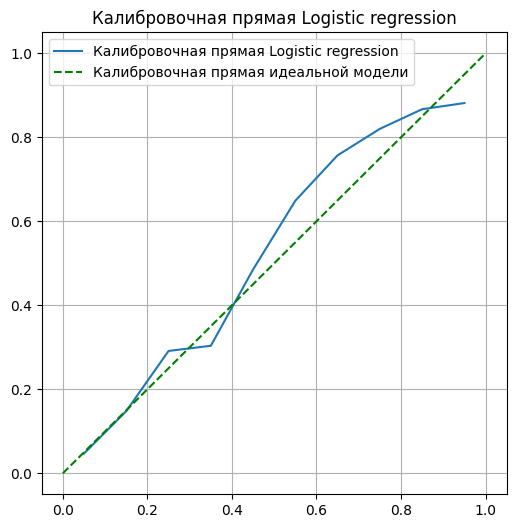

In [112]:
model = LogisticRegression()
model.fit(X_train, y_train)

lr = model.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr, "Калибровочная прямая Logistic regression")
plt.plot([0, 1], [0, 1], label="Калибровочная прямая идеальной модели", linestyle="--", color="green")

plt.title("Калибровочная прямая Logistic regression")
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(True)

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


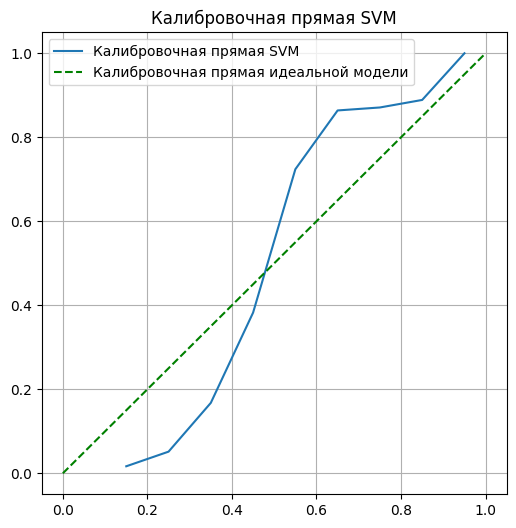

In [119]:
model = LinearSVC()
model.fit(X_train, y_train)

svc = model.decision_function(X_test)
svc = 1 / (1 + np.exp(-svc))
plot_calibration_curve(y_test, svc, label="Калибровочная прямая SVM")
plt.plot([0, 1], [0, 1], label="Калибровочная прямая идеальной модели", linestyle="--", color="green")

plt.title("Калибровочная прямая SVM")
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(True)

plt.show()


**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** для логистической регрессии кривая хорошо откалибрована, для SVM нет

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

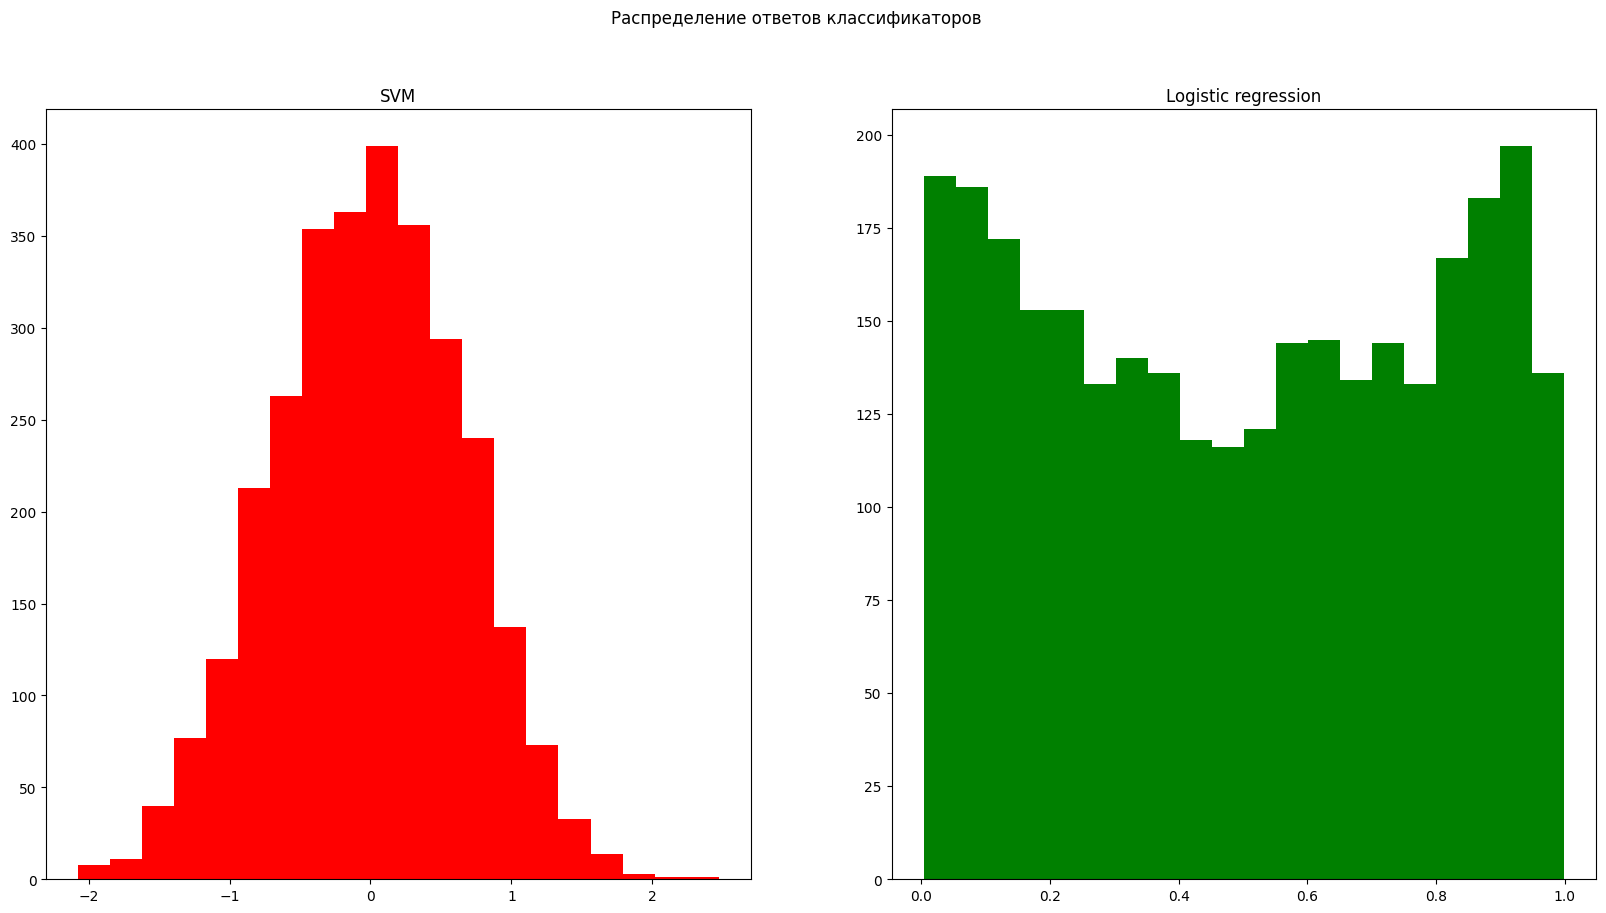

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[1].hist(lr, bins=20, color="green")
axs[0].hist(svc, bins=20, color="red")
axs[0].set_title("SVM")
axs[1].set_title("Logistic regression")

plt.suptitle("Распределение ответов классификаторов")
plt.show()


**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** у SVM распределение ответов похоже на нормальное, у Logistic Regression похоже больше на равномерное. Это взаимосвязано с тем, как показывают себя соответствующие калибровочные прямые + log reg более хорошая модель в данном случае

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [311]:
#your code here
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** должна была улучшиться с помощью calibration_curve, но я не успел(

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [312]:
df = pd.read_csv('bike_buyers.csv')

<Axes: xlabel='Age', ylabel='Count'>

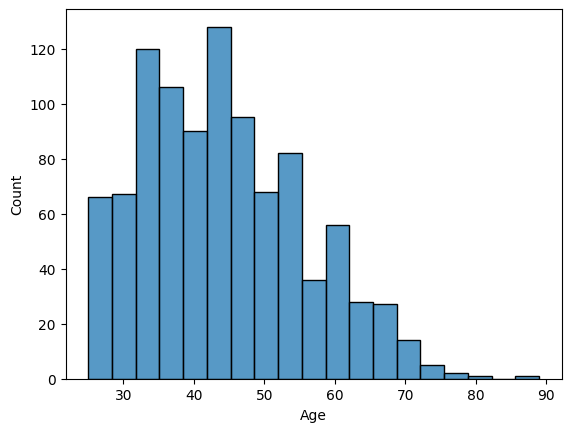

In [313]:
sns.histplot(df['Age'])

In [314]:
df.isna().sum()

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [315]:
isna_columns = ['Marital Status', 'Gender', 'Home Owner']
df[isna_columns] = df[isna_columns].fillna('undefined')
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

In [316]:
numerical_features = ['Age', 'Children', 'Cars', 'Income']
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Region', 'Commute Distance']
X_numerical = X[numerical_features]
X_categorical = X[categorical_features]

In [317]:
X_categorical.isna().sum()

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Region              0
Commute Distance    0
dtype: int64

В начале поработаем только с категориальными признаками

In [318]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [319]:
#your code here
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import time

In [320]:
s = time.time()

enc = OrdinalEncoder()

x_train_new = enc.fit_transform(X_train)
x_test_new = enc.transform(X_test)

log = LogisticRegression()
log.fit(x_train_new, y_train)

y_pred = log.predict_proba(x_test_new)[:, 1]

print("AUC-PR score:", auc_pr_count(y_test, y_pred))
print("Всего времени sec:", time.time() - s)

AUC-PR score: 0.5789437602089755
Всего времени sec: 0.014750480651855469


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [321]:
#your code here
s = time.time()

encoder = OneHotEncoder()

X_train_ohe = encoder.fit_transform(X_train)
X_test_ohe = encoder.transform(X_test)

model = LogisticRegression()

model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:, 1]

print("AUC-PR score =", auc_pr_count(y_test, y_pred))
print("Total time secs: ", time.time() - s)

AUC-PR score = 0.6618645231989089
Total time secs:  0.03020453453063965


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [322]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.values = dict([[i, dict()] for i in self.columns])

    def fit(self, X, y):

        for i in self.values:
            for j in X[i].unique():
                value = ((j == X[i]) & (y == 1)).sum() / (j == X[i]).sum()
                self.values[i][j] = value
        return self

    def transform(self, X):
        X_c = X.copy()
        for i in self.columns:
            vals = []
            for _, row in X.iterrows():
                vals.append(self.values[i][row[i]])
            X_c[i] = vals
        return X_c

In [323]:
s = time.time()
column_transformer = ColumnTransformer([
        ('mte', MeanTargetEncoder(X_train.columns), categorical_features),
])

pipeline = Pipeline(steps=[
        ('mte', column_transformer),
        ('regression', LogisticRegression())
]
)

model = pipeline.fit(X_train[categorical_features], y_train)

y_pred = model.predict_proba(X_test[categorical_features])[:, 1]

print("AUC-PR score =", auc_pr_count(y_test, y_pred))
print("Total time secs: ", time.time() - s)

AUC-PR score = 0.6526670066993725
Total time secs:  0.6699583530426025


Время существенно возросло по сравнению с предыдущими способами.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [324]:
#your code here

class MeanTargetEncoderBoost(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.values = dict([[i, dict()] for i in self.columns])

    def fit(self, X, y):
        for i in self.values:
            for j in X[i].unique():
                value = ((j == X[i]) & (y == 1)).sum() / (j == X[i]).sum()
                self.values[i][j] = value
        return self

    def transform(self, X):
        X_c = X.copy()
        for i in self.columns:
            X_c[i] = X_c[i].map(lambda row: self.values[i][row[i]])
        return X_c

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [325]:
#your code here
s = time.time()
encoder = MeanTargetEncoder(X_train.columns)

first = np.logspace(-4, 3, 6)
second = np.logspace(-4, 3, 6)
for i in first:
    for j in second:
        s = time.time()
        X_train_target_noise = encoder.fit_transform(X_train, y_train) + np.random.normal(i, j)
        X_test_target_noise = encoder.transform(X_test) + np.random.normal(i, j)

        model = LogisticRegression()

        model.fit(X_train_target_noise, y_train)
        y_pred = model.predict_proba(X_test_target_noise)[:, 1]
        print(f"On random normal with parameters: {i} and {j}:")
        print("AUC-PR score =", auc_pr_count(y_test, y_pred))
        print("Total time secs: ", time.time() - s)
        print("--------------")

On random normal with parameters: 0.0001 and 0.0001:
AUC-PR score = 0.652694015966057
Total time secs:  0.5542850494384766
--------------
On random normal with parameters: 0.0001 and 0.0025118864315095794:
AUC-PR score = 0.652694015966057
Total time secs:  0.5405333042144775
--------------
On random normal with parameters: 0.0001 and 0.0630957344480193:
AUC-PR score = 0.652694015966057
Total time secs:  0.5278110504150391
--------------
On random normal with parameters: 0.0001 and 1.584893192461111:
AUC-PR score = 0.652694015966057
Total time secs:  0.5344550609588623
--------------
On random normal with parameters: 0.0001 and 39.81071705534969:
AUC-PR score = 0.6066817123476801
Total time secs:  0.5315225124359131
--------------
On random normal with parameters: 0.0001 and 1000.0:
AUC-PR score = 0.6591903776373649
Total time secs:  0.3392653465270996
--------------
On random normal with parameters: 0.0025118864315095794 and 0.0001:
AUC-PR score = 0.6526670066993725
Total time secs:  0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On random normal with parameters: 0.0630957344480193 and 39.81071705534969:
AUC-PR score = 0.6508370493329032
Total time secs:  0.36190366744995117
--------------
On random normal with parameters: 0.0630957344480193 and 1000.0:
AUC-PR score = 0.6591665286569433
Total time secs:  0.3342740535736084
--------------
On random normal with parameters: 1.584893192461111 and 0.0001:
AUC-PR score = 0.6526670066993725
Total time secs:  0.36405205726623535
--------------
On random normal with parameters: 1.584893192461111 and 0.0025118864315095794:
AUC-PR score = 0.652694015966057
Total time secs:  0.3455963134765625
--------------
On random normal with parameters: 1.584893192461111 and 0.0630957344480193:
AUC-PR score = 0.652694015966057
Total time secs:  0.3346831798553467
--------------
On random normal with parameters: 1.584893192461111 and 1.584893192461111:
AUC-PR score = 0.652694015966057
Total time secs:  0.3524441719055176
--------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On random normal with parameters: 1.584893192461111 and 39.81071705534969:
AUC-PR score = 0.652501342411943
Total time secs:  0.35654759407043457
--------------
On random normal with parameters: 1.584893192461111 and 1000.0:
AUC-PR score = 0.3731536981835986
Total time secs:  0.33446741104125977
--------------
On random normal with parameters: 39.81071705534969 and 0.0001:
AUC-PR score = 0.6066817123476801
Total time secs:  0.3545956611633301
--------------
On random normal with parameters: 39.81071705534969 and 0.0025118864315095794:
AUC-PR score = 0.6066817123476801
Total time secs:  0.3483462333679199
--------------
On random normal with parameters: 39.81071705534969 and 0.0630957344480193:
AUC-PR score = 0.6067119323209741
Total time secs:  0.337878942489624
--------------
On random normal with parameters: 39.81071705534969 and 1.584893192461111:
AUC-PR score = 0.6066514520378146
Total time secs:  0.3426666259765625
--------------
On random normal with parameters: 39.81071705534969

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** добавление шума не помогло, потому что это случайные все-таки числа, я постарался перебрать побольше вариантов, все-таки где-то шум оставил уровень модели на приемлемом уровне, но вот где-то можно увидеть критические проседания качества

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [326]:
#your code here

class MeanTargetEncoderNew(BaseEstimator, TransformerMixin):

    def __init__(self, columns, c=10):
        self.columns = columns
        self.values = dict([[i, dict()] for i in self.columns])
        self.c = c

    def fit(self, X, y):
        global_mean = y.mean()

        for i in self.values:
            for j in X[i].unique():

                value = (((j == X[i]) & (y == 1)).sum() + self.c * global_mean) / ((j == X[i]).sum() + self.c)

                self.values[i][j] = value

        return self

    def transform(self, X):
        X_c = X.copy()
        for i in self.columns:

            vals = []

            for _, row in X.iterrows():
                vals.append(self.values[i][row[i]])

            X_c[i] = vals

        return X_c

In [145]:
c_param = np.linspace(-20, 25, 45)

for c in c_param:
    column_transformer = ColumnTransformer([
        ('mte', MeanTargetEncoderNew(X_train.columns, c), categorical_features),
    ])

    pipeline = Pipeline(steps=[
        ('mte', column_transformer),
        ('regression', LogisticRegression())
    ]
    )

    model = pipeline.fit(X_train[categorical_features], y_train)

    y_pred = model.predict_proba(X_test[categorical_features])[:, 1]

    if best_auc_pr < auc_pr_count(y_test, y_pred):
        best_auc_pr = auc_pr_count(y_test, y_pred)
        best_c = c

print("Best AUC-PR score =", best_auc_pr)
print("Best C parameter: ", best_c)

Best AUC-PR score = 0.6980727578704384
Best C parameter:  -9.09090909090908


Качество стало лучше, чем в OHE: 0.698 против 0.6618

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [327]:
#your code here
X_numerical.isna().sum()

Age         8
Children    8
Cars        9
Income      6
dtype: int64

In [328]:
X_numerical['Age'].fillna(X_numerical['Age'].mean(), inplace=True)
X_numerical['Children'].fillna(X_numerical['Children'].mean(), inplace=True)
X_numerical['Cars'].fillna(X_numerical['Cars'].mean(), inplace=True)
X_numerical['Income'].fillna(X_numerical['Income'].mean(), inplace=True)

<ipython-input-328-01682739083e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical['Age'].fillna(X_numerical['Age'].mean(), inplace=True)
<ipython-input-328-01682739083e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical['Children'].fillna(X_numerical['Children'].mean(), inplace=True)
<ipython-input-328-01682739083e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical['Cars'].fillna(X_numerical['Cars'].me

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [329]:
#your code here
X_numerical.nunique()

Age         54
Children     7
Cars         6
Income      17
dtype: int64

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ плюсы - счетчики экономят память, минусы - учатся гораздо дольше, чем OHE

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [122]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 15:20:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  6.71MB/s    in 0.6s    

2023-11-22 15:21:00 (6.71 MB/s) - ‘adult.data’ saved [3974305]



In [123]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
8212,32,Private,73621,Some-college,10,Divorced,Exec-managerial,Unmarried,White,Female,0,0,42,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [124]:
#your code here
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="income"), df["income"], test_size=0.25, stratify=df["income"], random_state=777)
X_train = X_train.reset_index().drop('index', axis=1)
X_test = X_test.reset_index().drop('index', axis=1)
y_train = y_train.reset_index().drop('index', axis=1)
y_test = y_test.reset_index().drop('index', axis=1)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [147]:
#your code here
categorical_features = ["workclass", "education",  "education-num", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
numerical_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]

In [148]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [150]:
print("Всего кат. признаков до OHE:", len(categorical_features))
enc = OneHotEncoder()
print("Всего кат. признаков после OHE:", enc.fit_transform(X_train[categorical_features]).shape[1])

Всего кат. признаков до OHE: 9
Всего кат. признаков после OHE: 118


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [151]:
#your code here
from sklearn.linear_model import LogisticRegression
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numerical_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logistic_regression', LogisticRegression())
]
)

In [152]:
model = pipeline.fit(X_train[np.concatenate([categorical_features, numerical_features])], y_train)
y_pred = model.predict(X_test[np.concatenate([categorical_features, numerical_features])])

print("Test AUC-ROC = %.4f" % auc_pr_count(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test AUC-ROC = 0.7181


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



вот тут нарыл то, что нужно, но какая это жесть это искать......

https://medium.com/nuances-of-programming/19-%D1%81%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D1%85-%D1%84%D0%B8%D1%87-sklearn-%D0%BE-%D0%BA%D0%BE%D1%82%D0%BE%D1%80%D1%8B%D1%85-%D0%B2%D0%B0%D0%BC-%D1%81%D0%BB%D0%B5%D0%B4%D1%83%D0%B5%D1%82-%D0%B7%D0%BD%D0%B0%D1%82%D1%8C-a4ef520ff212

In [153]:
#your code here
from sklearn.feature_selection import SelectFromModel

In [330]:
print(pipeline.named_steps['logistic_regression'].coef_[0])
feat = np.sort(np.abs(pipeline.named_steps['regression'].coef_[0]))[:-40]
feat

KeyError: ignored

Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
#your code here

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
#your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [155]:
import pandas as pd

In [217]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-22 16:43:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.2’

bank-additional.zip     [  <=>               ] 434.15K  1.29MB/s    in 0.3s    

2023-11-22 16:43:42 (1.29 MB/s) - ‘bank-additional.zip.2’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bank-additional/.DS_Store  
replace __MACOSX/bank-additional/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/bank-additional/._.DS_Store  
replace bank-additional/.Rhistory? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bank-additional/.Rhistory  
replace bank-additional/bank-additional-full.csv? [y]es, [n]o, [A]ll, [N]

In [218]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [221]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [222]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [220]:
from sklearn.model_selection import KFold

In [223]:
# your code here
kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [278]:
# your code here
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome']
numeric_features = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
]
)

print(kf.split(X))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    print("For fold", i + 1, "AUC-PR =", auc_pr_count(y_test, y_pred))

<generator object _BaseKFold.split at 0x7ae780cd5af0>
For fold 1 AUC-PR = 0.4821170646290468
For fold 2 AUC-PR = 0.43700525228268555
For fold 3 AUC-PR = 0.44822524408568076
For fold 4 AUC-PR = 0.4581639284977346
For fold 5 AUC-PR = 0.42854536505836566


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [279]:
# your code here
finances_plus = []
finances_minus = []
diff = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = pipeline.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    finances_plus.append((y_pred & y_test).sum() * 10)

    finances_minus.append(y_pred.sum())

    diff.append(finances_plus[-1] - finances_minus[-1])

    print("For fold", i + 1, "AUC-PR =", auc_pr_count(y_test, y_pred))

print("Средняя выручка:", np.mean(diff))
print("Стандартное отклонение выручки:", np.std(diff))
print("Средний заработок:", np.mean(finances_plus))
print("Средняя ЗП операторам:", np.mean(finances_minus))

For fold 1 AUC-PR = 0.5258596649340994
For fold 2 AUC-PR = 0.46607908046946567
For fold 3 AUC-PR = 0.48127286097956934
For fold 4 AUC-PR = 0.5084442015058629
For fold 5 AUC-PR = 0.45842960683787376
Средняя выручка: 1795.4
Стандартное отклонение выручки: 103.69300844319255
Средний заработок: 2116.0
Средняя ЗП операторам: 320.6


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [280]:
#your code here# your code here
finances_plus = []
finances_minus = []
diff = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = pipeline.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    finances_plus.append((y_pred & y_test).sum() * np.random.uniform(0, 20))

    finances_minus.append(y_pred.sum())

    diff.append(finances_plus[-1] - finances_minus[-1])

    print("For fold", i + 1, "AUC-PR =", auc_pr_count(y_test, y_pred))

print("Средняя выручка:", np.mean(diff))
print("Стандартное отклонение выручки:", np.std(diff))
print("Средний заработок:", np.mean(finances_plus))
print("Средняя ЗП операторам:", np.mean(finances_minus))

For fold 1 AUC-PR = 0.5258596649340994
For fold 2 AUC-PR = 0.46607908046946567
For fold 3 AUC-PR = 0.48127286097956934
For fold 4 AUC-PR = 0.5084442015058629
For fold 5 AUC-PR = 0.45842960683787376
Средняя выручка: 976.3600269818282
Стандартное отклонение выручки: 941.297072720454
Средний заработок: 1296.9600269818282
Средняя ЗП операторам: 320.6


В целом, выручка очень даже увеличилась, но и std сильно очень вырос, я прогнал это 2 раз, в 1 раз только выручка была чуть меньше первоначальной.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [281]:
#your code here
c_param = np.linspace(1, 20, 20)

max_amount_money = 0
best_c = c_param[0]
arr_amount_money = []
std_arr = []

for c in c_param:
    print("Current C:", c)
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=c, max_iter=1000))
    ])
    finances_plus = []
    finances_minus = []
    diff = []

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = pipeline.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        finances_plus.append((y_pred & y_test).sum() * np.random.uniform(0, 20))

        finances_minus.append(y_pred.sum())

        diff.append(finances_plus[-1] - finances_minus[-1])

    arr_amount_money.append(np.mean(diff))
    std_arr.append(np.std(diff))

    if max_amount_money < np.mean(diff):
        print("Update:", c, np.mean(diff))
        max_amount_money = np.mean(diff)
        best_c = c

print()
print("Лучший параметр C:", best_c)
print("Наибольшая выручка:",max_amount_money)

Current C: 1.0
Update: 1.0 2599.2084821819294
Current C: 2.0
Current C: 3.0
Current C: 4.0
Current C: 5.0
Current C: 6.0
Current C: 7.0
Current C: 8.0
Update: 8.0 2722.869200303042
Current C: 9.0
Update: 9.0 2807.160691868377
Current C: 10.0
Current C: 11.0
Current C: 12.0
Current C: 13.0
Current C: 14.0
Current C: 15.0
Current C: 16.0
Current C: 17.0
Current C: 18.0
Current C: 19.0
Current C: 20.0

Лучший параметр C: 9.0
Наибольшая выручка: 2807.160691868377


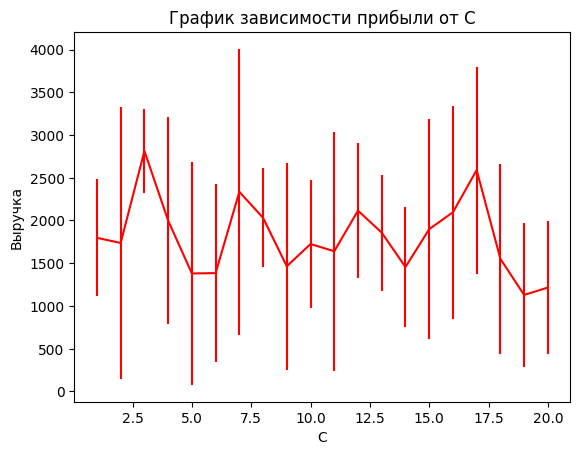

In [273]:
plt.errorbar(c_param, arr_amount_money, yerr=std_arr, color='red')
plt.ylabel('Выручка')
plt.xlabel('C')
plt.title('График зависимости прибыли от C')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [271]:
#your code here
#your code here
c_param = np.linspace(1, 20, 20)

max_amount_money = 0
best_c = c_param[0]
arr_amount_money = []
std_arr = []

for c in c_param:
    print("Current C:", c)
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=c, max_iter=1000))
    ])
    finances_plus = []
    finances_minus = []
    diff = []

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = pipeline.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        finances_plus.append((y_pred & y_test).sum() * np.random.uniform(0, 20))

        finances_minus.append(y_pred.sum())

        diff.append(finances_plus[-1] - finances_minus[-1])

    arr_amount_money.append(np.mean(diff))
    std_arr.append(np.std(diff))

    if max_amount_money < np.mean(diff):
        print("Update:", c, np.mean(diff))
        max_amount_money = np.mean(diff)
        best_c = c

print()
print("Лучший параметр C:", best_c)
print("Наибольшая выручка:",max_amount_money)

Current C: 1.0
Update: 1.0 1796.1563274800876
Current C: 2.0
Current C: 3.0
Update: 3.0 2812.2349800899924
Current C: 4.0
Current C: 5.0
Current C: 6.0
Current C: 7.0
Current C: 8.0
Current C: 9.0
Current C: 10.0
Current C: 11.0
Current C: 12.0
Current C: 13.0
Current C: 14.0
Current C: 15.0
Current C: 16.0
Current C: 17.0
Current C: 18.0
Current C: 19.0
Current C: 20.0

Лучший параметр C: 3.0
Наибольшая выручка: 2812.2349800899924


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ нам важнее precision, поскольку нам важно именно привлечь клиента, то есть нам важно позвать именно клиента, он дает весомый доход. Если мы будем брать recall больше, то у нас ниже будет шанс привлечь клиента, поиски могут затянуться и в итоге можно вообще не привлечь почти клиентов, но потенциально охватить больше(хотя это мало что даст, ведь их не привлекли из-за сниженного recall)



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [295]:
#your code here
column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(max_iter=1000))
])

binary_border = np.linspace(0, 1, 100)
best_border = binary_border[0]
max_amount_money = 0

arr_amount_money = []
std_arr = []

for border in binary_border:
    print("Current border:", border)

    finances_plus = []
    finances_minus = []
    diff = []

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = pipeline.fit(X_train, y_train)

        y_pred = model.predict_proba(X_test)[:, 1]

        y_pred = np.where(y_pred >= border, 1, 0)

        finances_plus.append((y_pred & y_test).sum() * np.random.uniform(0, 20))

        finances_minus.append(y_pred.sum())

        diff.append(finances_plus[-1] - finances_minus[-1])

    x = np.mean(diff)
    arr_amount_money.append(x)
    std_arr.append(np.std(diff))

    if max_amount_money < x:
        print("Update:", border, x)
        max_amount_money = x
        best_border = border

Current border: 0.0
Update: 0.0 619.1527792973532
Current border: 0.010101010101010102
Current border: 0.020202020202020204
Update: 0.020202020202020204 637.915503067435
Current border: 0.030303030303030304
Update: 0.030303030303030304 3157.76564448539
Current border: 0.04040404040404041
Update: 0.04040404040404041 3184.4203807420618
Current border: 0.05050505050505051
Update: 0.05050505050505051 5037.150274549791
Current border: 0.06060606060606061
Current border: 0.07070707070707072
Current border: 0.08080808080808081
Update: 0.08080808080808081 6517.309166830843
Current border: 0.09090909090909091
Current border: 0.10101010101010102
Current border: 0.11111111111111112
Current border: 0.12121212121212122
Current border: 0.13131313131313133
Current border: 0.14141414141414144
Current border: 0.15151515151515152
Current border: 0.16161616161616163
Current border: 0.17171717171717174
Current border: 0.18181818181818182
Current border: 0.19191919191919193
Current border: 0.20202020202020

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [296]:
best_border

0.08080808080808081

<ipython-input-297-dc9bf042ee5f>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(binary_border, arr_amount_money, yerr=std_arr, fmt='.k', color='red')


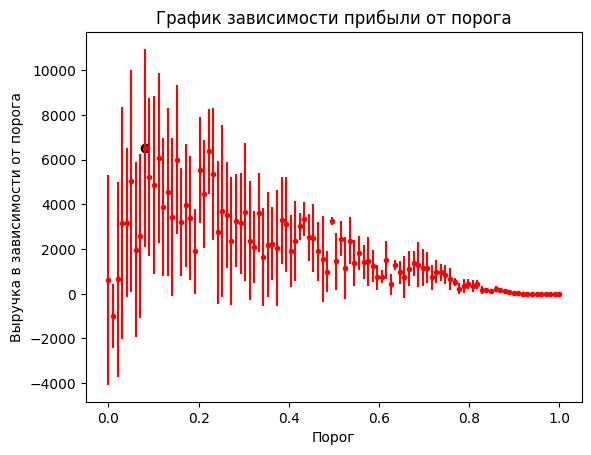

In [297]:
#your code here
plt.errorbar(binary_border, arr_amount_money, yerr=std_arr, fmt='.k', color='red')
plt.ylabel('Выручка в зависимости от порога')
plt.xlabel('Порог')
plt.title('График зависимости прибыли от порога')
plt.scatter(best_border, max_amount_money, color='black')
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ я запускал это все несколько раз, и есть закономерности, что где-то до порога 0.2 мы наблюдаем довольно высокие значения прибыли, причем на начальных этапах начиная с 0 мы даже уходим в минус по прибыли, потому что оно и понятно - у нас recall максимальный, precision никакой, отсюда обзваниваем всех, но получается это некачественно и привлечь клиента почти невозможно. Но в районе 0.1 порога уже все хорошо, там наблюдается максимальная прибыль(0.08 порог), то есть резко выросло, а потом после 0.2 выручка начинает падать и затухать быстрее к 0, оно тоже понятно, ведь recall все меньше и меньше и шанс найти клиента нужного все меньше и меньше и в конце улетает в 0.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [298]:
from sklearn.metrics import recall_score, precision_score

In [299]:
#your code here
prec_arr, rec_arr = [], []
finances_plus = []
finances_minus = []
diff = []
print(best_border)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = pipeline.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]

    y_pred = np.where(y_pred >= best_border, 1, 0)

    prec_arr.append(precision_score(y_test, y_pred))
    rec_arr.append(recall_score(y_test, y_pred))

    finances_plus.append((y_pred & y_test).sum() * np.random.uniform(0, 20))

    finances_minus.append(y_pred.sum())

    diff.append(finances_plus[-1] - finances_minus[-1])


print("Средний recall:",  np.mean(rec_arr))
print("Средний precision:", np.mean(prec_arr))
print("Стандартное отклонение:", np.std(diff))

0.08080808080808081
Средний recall: 0.7016066963200915
Средний precision: 0.2672636893751551
Стандартное отклонение: 3869.26200418097


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC-PR: 0.12474


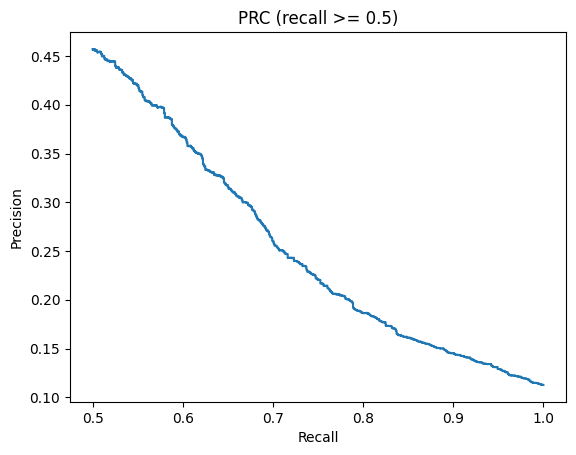

In [310]:
#your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=777)
X_train = X_train.reset_index().drop(columns="index")
X_test = X_test.reset_index().drop(columns="index")
y_train = y_train.reset_index().drop(columns="index")
y_test = y_test.reset_index().drop(columns="index")

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
]
)

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)

recall = recall[recall >= 0.5]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
new_precision = precision[recall >= 0.5]
new_recall = recall[recall >= 0.5]
print('AUC-PR: %.5f' % auc(new_recall, new_precision))
plt.plot(new_recall, new_precision)
plt.title("PRC (recall >= 0.5)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ паровой омлет с черри